[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Moorea-AI/AI4ENG_UDEA/blob/main/01_Exploracion_De_Datos.ipynb)

#EXPLORACIÓN DE DATOS PARA EL DATASET "Fraude en Transacciones Electrónicas" <br>
###TOMADO DE: https://www.kaggle.com/competitions/ieee-fraud-detection/data?select=test_transaction

Presentado por: </br>
Aura Luz Moreno Díaz, Estudiante de Ingeniería Industrial </br>
Evelyn Zharick Saez Gallego, Estudiante de Ingeniería Ambiental</br></br>
Para la materia:<br>
INTRODUCCIÓN A LA INTELIGENCIA ARTIFICIAL PARA LAS CIENCIAS Y LA INGENIERIA<BR>
Con el profesor: RAÚL RAMOS POLLAN

In [15]:
#PASO 1: Importación de librerias que serán necesarias para la exploración de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
import json
import seaborn as sns

#Importacion de librerias para manipulación de datos para Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold

from scipy.stats import norm
from scipy import stats


import lightgbm as lgb
import gc

import warnings
warnings.filterwarnings('ignore')



##1. Lectura y concatenación de los Dataset

In [2]:
# Cargando credenciales de Kaggle
data = {"username":"mooreamed","key":"a253e996d6247d9093be1edd604d0125"}
with open('kaggle.json', 'w') as file:
    json.dump(data, file, indent=4)

#!cp kaggle.json ~/.kaggle/

In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Se descarga el dataset
!kaggle datasets download -d niangmohamed/ieeecis-fraud-detection

# Se descomprime el dataset
!unzip ieeecis-fraud-detection.zip

ieeecis-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ieeecis-fraud-detection.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [9]:
#Verificamos que se este funcionando la conexión de la API
!kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          21830        605  1.0              
mauryansshivam/netflix-ott-revenue-and-subscribers-csv-file           Netflix OTT Revenue and Subscribers (CSV File)        2KB  2023-05-13 17:40:23            936         23  1.0              
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           2371         56  1.0              
darshanprabhu09/stock-prices-f

### ANALISIS DE LOS DATOS

####**TABLA IDENTITY** <BR>
Las variables en esta tabla son información de identidad: 
<BR><BR>
información de conexión de red (IP, ISP, Proxy, etc.) y firma digital (UA/
navegador/OS/versión, etc.) asociada con las transacciones.<BR><BR>
Son recopilados por el sistema de protección contra fraudes de Vesta y los socios de seguridad digital.<BR><BR>
(Los nombres de los campos están enmascarados y no se proporcionará el diccionario por pares para la protección de la privacidad y el acuerdo del contrato)<BR><BR>

TransactionID<br>
id_12 - id_38<BR>
DeviceType<BR>
DeviceInfo<BR>
<BR>
####**TABLA TRANSACCIONES:** <BR>

TransactionDT: timedelta de una fecha y hora de referencia determinada (no una marca de tiempo real). timedelta de una fecha y hora de referencia dada (no una marca de tiempo real). El primer valor de TransactionDT es 86400, que corresponde a la cantidad de segundos en un día (60 * 60 * 24 = 86400), así que creo que la unidad es segundos. Usando esto, sabemos que los datos abarcan 6 meses, ya que el valor máximo es 15811131, que correspondería al día 183”
<BR>

TransactionAMT: monto del pago de la transacción en USD<BR>

ProductCD: código de producto, el producto para cada transacción<BR>

card1 - card6: información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc.<BR>

dirección: dirección addr1 como región de facturación, addr2 como país de facturación<BR>

distancia: distancias entre (no limitadas) la dirección de facturación, la dirección postal, el código postal, la dirección IP, el área telefónica, etc
<BR>

P_ y (R__) emaildomain: dominio de correo electrónico del comprador y del destinatario<BR>

C1-C14: conteo, como cuántas direcciones se encuentran asociadas con la tarjeta de pago, etc. El significado real está enmascarado.<BR>

D1-D15: timedelta, como días entre transacciones anteriores, etc.<BR>

M1-M9: coincidencia, como nombres en la tarjeta y dirección, etc.<BR>

Vxxx: características completas diseñadas por Vesta, que incluyen clasificación, conteo y otras relaciones de entidad.<BR><BR>

Características categóricas:<BR>

ProductCD<BR>
card1 - card6<BR>
addr1, addr2<BR>
P_emaildomain<BR>
R_emaildomain<BR>
M1 - M9<BR>




In [2]:
#Lectura  los datos que tiene el dataset para empezar con el análisis exploratorio
#Lo llamaremos df por dataframe, tid por transactions id para que quede dftid

dftid = pd.read_csv('train_identity.csv')
dftid.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,...,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [22]:
#Se imprimen las columnas para poder identificarlas y seleccionar cuáles serán susceptibles de análisis. 
#Para esto, tomaremos solamente la tabla de identidad
dftid.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [12]:
#Para cumplir el requerimiento solicitado por el trabajo académico, tenemos 41 columnas y 141.907 instancias
dftid.shape

(144233, 41)

In [13]:
#Y la info exacta del DF
dftid.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [11]:
#Debemos verificar cuántos valores nulos tenemos en la tabla, para esto hacemos el chequeo asi:
check_for_any_nan= dftid.isna().any().any()#Vamos a encontrar cuantos NaN existen en el dataframe
total_nan_values = dftid.isna().sum().sum()#Vamos a sumar el total NaN presente en el dataframe
fil ,col = dftid.shape
num_datos = fil*col
print("Existen valores NaN: "+str(check_for_any_nan))
print("Total de valores NaN: "+str(total_nan_values))
#print("El porcentaje de valores NaN: " +str((total_nan_values*100)/num_datos) + "%")
print("El porcentaje de valores NaN: {:.1f}%".format(round((total_nan_values*100)/num_datos, 1)))


Existen valores NaN: True
Total de valores NaN: 2104107
El porcentaje de valores NaN: 35.6%


Según el dato anterior, tenemos 2.104.107 de datos nulos, es decir, superior al 5%, ya que tenemos un total de 5.913.553 datos. <br>
Con esto se cumple la condición solicitada en el trabajo académico ya que tenemos el 35.6% de datos nulos

In [14]:
dftid.isnull().sum() #Columnas con valores nulos

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

In [13]:
#Queremos saber cual es el promedio de cada columna con valores nulos.
dftid.isnull().mean() * 100 

TransactionID     0.000000
id_01             0.000000
id_02             2.330257
id_03            54.016071
id_04            54.016071
id_05             5.108401
id_06             5.108401
id_07            96.425922
id_08            96.425922
id_09            48.052110
id_10            48.052110
id_11             2.256765
id_12             0.000000
id_13            11.726165
id_14            44.503685
id_15             2.251912
id_16            10.325654
id_17             3.372321
id_18            68.722137
id_19             3.407681
id_20             3.447200
id_21            96.423149
id_22            96.416215
id_23            96.416215
id_24            96.708798
id_25            96.441868
id_26            96.420375
id_27            96.416215
id_28             2.256765
id_29             2.256765
id_30            46.222432
id_31             2.739318
id_32            46.207872
id_33            49.187079
id_34            46.056034
id_35             2.251912
id_36             2.251912
i

Del resultado anterior, podemos ver que existen varias columnas con un gran porcentaje de datos nulos, por ende podrían ser susceptibles de ser borradas una vez sean analizados para saber si se tienen en cuenta o no para los fines del trabajo académico.

In [3]:
dftid_sinNaN = dftid.dropna() #eliminamos todas las columnas con valores en NaN
dftid_sinNaN.isnull().sum() #Verificamos si las filas en NaN fueron eliminadas

TransactionID    0
id_01            0
id_02            0
id_03            0
id_04            0
id_05            0
id_06            0
id_07            0
id_08            0
id_09            0
id_10            0
id_11            0
id_12            0
id_13            0
id_14            0
id_15            0
id_16            0
id_17            0
id_18            0
id_19            0
id_20            0
id_21            0
id_22            0
id_23            0
id_24            0
id_25            0
id_26            0
id_27            0
id_28            0
id_29            0
id_30            0
id_31            0
id_32            0
id_33            0
id_34            0
id_35            0
id_36            0
id_37            0
id_38            0
DeviceType       0
DeviceInfo       0
dtype: int64

In [25]:
dftid_sinNaN

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
19,2987099,-10.0,129080.0,0.0,0.0,9.0,-43.0,22.0,-34.0,0.0,...,mobile safari generic,32.0,1334x750,match_status:2,T,F,T,F,mobile,iOS Device
370,2988702,-20.0,171610.0,0.0,0.0,13.0,-34.0,2.0,-33.0,0.0,...,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,T,T,mobile,iOS Device
372,2988706,-20.0,50100.0,0.0,0.0,12.0,-34.0,2.0,-33.0,0.0,...,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,T,T,mobile,iOS Device
375,2988714,-55.0,83328.0,0.0,0.0,9.0,-100.0,17.0,-13.0,0.0,...,ie 11.0 for desktop,24.0,1440x900,match_status:2,T,T,T,T,desktop,Trident/7.0
604,2990059,-100.0,773938.0,0.0,0.0,0.0,-1.0,18.0,-50.0,0.0,...,chrome 62.0,24.0,1280x1024,match_status:2,T,F,T,T,desktop,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143395,3572892,-30.0,267420.0,0.0,0.0,9.0,-34.0,16.0,-43.0,0.0,...,google,32.0,2048x1536,match_status:2,T,F,T,F,mobile,iOS Device
143476,3573334,-5.0,34007.0,0.0,0.0,-6.0,-30.0,25.0,-34.0,0.0,...,mobile safari 11.0,32.0,2436x1125,match_status:2,T,F,T,T,mobile,iOS Device
143477,3573336,-5.0,33041.0,0.0,0.0,-6.0,-30.0,27.0,-34.0,0.0,...,mobile safari 11.0,32.0,2436x1125,match_status:1,T,F,T,T,mobile,iOS Device
143591,3573907,-20.0,1408.0,0.0,0.0,15.0,-33.0,20.0,-100.0,0.0,...,samsung browser 4.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,SAMSUNG-SM-G900A Build/MMB29M


In [16]:
dftid_sinNaN.info() #comprobamos que ya no hay datos nulos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 19 to 144207
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  935 non-null    int64  
 1   id_01          935 non-null    float64
 2   id_02          935 non-null    float64
 3   id_03          935 non-null    float64
 4   id_04          935 non-null    float64
 5   id_05          935 non-null    float64
 6   id_06          935 non-null    float64
 7   id_07          935 non-null    float64
 8   id_08          935 non-null    float64
 9   id_09          935 non-null    float64
 10  id_10          935 non-null    float64
 11  id_11          935 non-null    float64
 12  id_12          935 non-null    object 
 13  id_13          935 non-null    float64
 14  id_14          935 non-null    float64
 15  id_15          935 non-null    object 
 16  id_16          935 non-null    object 
 17  id_17          935 non-null    float64
 18  id_18 

In [4]:
#creamos una nueva tabla 'identidad' con las columnas seleccionadas, ya que no necesitamos todo el dataset original para hacer los análisis que nos interesan.

identidad = dftid[['TransactionID', 'id_23', 'id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']].copy()

In [5]:
#cambiamos los nombres de las columnas en la tabla 'transacciones' por los que nos interesan para que sean identificables
identidad = identidad.rename(columns={'TransactionID': 'IdTransaccion',
                                              'id_23': 'Proxy',
                                              'id_30': 'SistemaOperativo',
                                              'id_31': 'Navegador',
                                              'id_33': 'Resolucion',
                                              'DeviceType': 'TipoDispositivo',
                                              'DeviceInfo': 'InfoDispositivo'})
identidad

,IdTransaccion,Proxy,SistemaOperativo,Navegador,Resolucion,TipoDispositivo,InfoDispositivo
0,2987004,NaN,Android 7.0,samsung browser 6.2,2220x1080,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,NaN,iOS 11.1.2,mobile safari 11.0,1334x750,mobile,iOS Device
2,2987010,NaN,NaN,chrome 62.0,NaN,desktop,Windows
3,2987011,NaN,NaN,chrome 62.0,NaN,desktop,NaN
4,2987016,NaN,Mac OS X 10_11_6,chrome 62.0,1280x800,desktop,MacOS
...,...,...,...,...,...,...,...
144228,3577521,NaN,NaN,chrome 66.0 for android,NaN,mobile,F3111 Build/33.3.A.1.97
144229,3577526,NaN,Android 7.1.1,chrome 55.0 for android,855x480,mobile,A574BL Build/NMF26F
144230,3577529,NaN,NaN,chrome 65.0 for android,NaN,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,NaN,Mac OS X 10_9_5,chrome 66.0,2560x1600,desktop,MacOS


In [15]:
#Empezamos a explorar los contenidos de las variables para estandarizarlos
identidad['Proxy'].value_counts()

IP_PROXY:TRANSPARENT    3489
IP_PROXY:ANONYMOUS      1071
IP_PROXY:HIDDEN          609
Name: Proxy, dtype: int64

In [6]:
#hacemos los cambios pertinentes para Proxy
identidad['Proxy'] = identidad['Proxy'].replace(['IP_PROXY:TRANSPARENT'], 'Transparent')
identidad['Proxy'] = identidad['Proxy'].replace(['IP_PROXY:ANONYMOUS'], 'Anonymous')
identidad['Proxy'] = identidad['Proxy'].replace(['IP_PROXY:HIDDEN'], 'Hidden')

In [17]:
#Ahora hacemos lo mismo para S.O.
identidad['SistemaOperativo'].value_counts().sort_values(ascending=True)

iOS 11.4.1              1
Windows                 3
Mac OS X 10_13_5        4
iOS 11.4.0              5
func                   10
                    ...  
Android 7.0          2871
iOS 11.1.2           3699
iOS 11.2.1           3722
Windows 7           13110
Windows 10          21155
Name: SistemaOperativo, Length: 75, dtype: int64

In [7]:
#Organizamos lo de iOS
identidad['SistemaOperativo'] = identidad['SistemaOperativo'].str.replace('_', '.')
identidad['SistemaOperativo'] = identidad['SistemaOperativo'].replace(['Ios', 'iOs', 'ioS', 'IOs', 'iOS', 'i0S'], 'IOS')
identidad['SistemaOperativo'] = identidad['SistemaOperativo'].apply(lambda x: x.lower().strip() if pd.notnull(x) else x )

In [30]:
#Hacemos lo mismo para la columna Navegador pero vemos que son demasiado asi que lo dejamos asi
identidad['Navegador'].value_counts().sort_values()

chrome 67.0 for android        1
firefox mobile 61.0            1
chrome 69.0                    1
chromium                       1
android                        1
                           ...  
safari generic              8195
ie 11.0 for desktop         9030
mobile safari generic      11474
mobile safari 11.0         13423
chrome 63.0                22000
Name: Navegador, Length: 130, dtype: int64

In [31]:
identidad['TipoDispositivo'].value_counts().sort_values(ascending=True)

mobile     55645
desktop    85165
Name: TipoDispositivo, dtype: int64

###############################################################################################








#           CON ESTO YA TENEMOS SOLAMENTE LOS DATOS QUE NOS INTERESAN PARA EL DASHBOARD EN LA TABLA DE IDENTIDAD







###############################################################################################

AHORA HACEMOS LO MISMO PARA LA OTRA TABLA
##TRANSACTIONS


TABLA TRANSACCIONES:
TransactionDT: timedelta de una fecha y hora de referencia determinada (no una marca de tiempo real). timedelta de una fecha y hora de referencia dada (no una marca de tiempo real). El primer valor de TransactionDT es 86400, que corresponde a la cantidad de segundos en un día (60 * 60 * 24 = 86400), así que creo que la unidad es segundos. Usando esto, sabemos que los datos abarcan 6 meses, ya que el valor máximo es 15811131, que correspondería al día 183”

TransactionAMT: monto del pago de la transacción en USD

ProductCD: código de producto, el producto para cada transacción

card1 - card6: información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc.

dirección: dirección addr1 como región de facturación, addr2 como país de facturación

distancia: distancias entre (no limitadas) la dirección de facturación, la dirección postal, el código postal, la dirección IP, el área telefónica, etc

P_ y (R__) emaildomain: dominio de correo electrónico del comprador y del destinatario

C1-C14: conteo, como cuántas direcciones se encuentran asociadas con la tarjeta de pago, etc. El significado real está enmascarado.

D1-D15: timedelta, como días entre transacciones anteriores, etc.

M1-M9: coincidencia, como nombres en la tarjeta y dirección, etc.

Vxxx: características completas diseñadas por Vesta, que incluyen clasificación, conteo y otras relaciones de entidad.

In [8]:
#Vamos a leer los datos que tiene el dataset para empezar con el análisis explorartorio
#El nombre será df por DataFrame, ttr por Tabla de TRansacciones
dfttr = pd.read_csv('train_transaction.csv')
dfttr.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#Se imprimen las columnas para poder identificarlas y seleccionar cuáles serán susceptibles de análisis. 
dfttr.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [148]:
#Para cumplir el requerimiento solicitado por el trabajo académico, tenemos 394 columnas y 590.540 instancias
dfttr.shape

(590540, 394)

In [9]:
#Debemos verificar cuántos valores nulos tenemos en la tabla, para esto hacemos el chequeo asi:
check_for_any_nan= dfttr.isna().any().any()#Vamos a encontrar cuantos valores NaN existen en el dataframe
total_nan_values = dfttr.isna().sum().sum()#Vamos a sumar el total de valores NaN presentes en el dataframe
fil ,col = dfttr.shape
num_datos = fil*col
print("Existen valores NaN: "+str(check_for_any_nan))
print("Total de valores NaN: "+str(total_nan_values))
#print("El porcentaje de valores NaN: " +str((total_nan_values*100)/num_datos) + "%")
print("El porcentaje de valores NaN: {:.1f}%".format(round((total_nan_values*100)/num_datos, 1)))

Existen valores NaN: True
Total de valores NaN: 95566686
El porcentaje de valores NaN: 41.1%


In [128]:
dfttr.isnull().sum() #Columnas con valores nulos

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [72]:
#Analizamos las variables que nos interesan.
unique_values = dfttr['isFraud'].unique()
print(unique_values)

[0 1]


In [151]:
unique_values = dfttr['TransactionDT'].unique()
print(unique_values)

[   86400    86401    86469 ... 15811079 15811088 15811131]


In [152]:
unique_values = dfttr['TransactionAmt'].unique()
print(unique_values)

[  68.5    29.     59.   ...  557.54 1659.95  400.78]


In [153]:
unique_values = dfttr['card4'].unique()
print(unique_values)

['discover' 'mastercard' 'visa' 'american express' nan]


In [154]:
unique_values = dfttr['card6'].unique()
print(unique_values)

['credit' 'debit' nan 'debit or credit' 'charge card']


In [155]:
unique_values = dfttr['P_emaildomain'].unique() 
print(unique_values)

[nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']


In [156]:
unique_values = dfttr['R_emaildomain'].unique() 
print(unique_values)

[nan 'gmail.com' 'hotmail.com' 'outlook.com' 'anonymous.com' 'charter.net'
 'prodigy.net.mx' 'comcast.net' 'live.com.mx' 'icloud.com' 'yahoo.com'
 'aol.com' 'juno.com' 'att.net' 'verizon.net' 'yahoo.com.mx'
 'bellsouth.net' 'servicios-ta.com' 'ymail.com' 'hotmail.es' 'msn.com'
 'optonline.net' 'live.com' 'gmx.de' 'aim.com' 'mail.com' 'me.com'
 'outlook.es' 'cox.net' 'earthlink.net' 'embarqmail.com' 'web.de'
 'sbcglobal.net' 'scranton.edu' 'mac.com' 'twc.com' 'roadrunner.com'
 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'frontiernet.net' 'gmail' 'live.fr'
 'q.com' 'yahoo.co.uk' 'windstream.net' 'suddenlink.net' 'hotmail.fr'
 'ptd.net' 'hotmail.de' 'frontier.com' 'cfl.rr.com' 'hotmail.co.uk'
 'netzero.com' 'netzero.net' 'yahoo.co.jp' 'rocketmail.com'
 'centurylink.net' 'protonmail.com' 'cableone.net' 'sc.rr.com']


In [10]:
# Crear una nueva tabla 'transacciones' con las columnas seleccionadas
transacciones = dfttr[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card4', 'card6', 'P_emaildomain']].copy()

In [11]:
# Cambiar los nombres de las columnas en la tabla 'transacciones'
transacciones = transacciones.rename(columns={'TransactionID': 'IdTransaccion',
                                              'isFraud': 'EsFraude',
                                              'TransactionDT': 'LineaDeTiempo',
                                              'TransactionAmt': 'MontoTransaccion',
                                              'card4': 'Franquicia',
                                              'card6': 'TipoTarjeta',
                                              'P_emaildomain': 'DominioCompra'})
transacciones

,IdTransaccion,EsFraude,LineaDeTiempo,MontoTransaccion,Franquicia,TipoTarjeta,DominioCompra
0,2987000,0,86400,68.50,discover,credit,NaN
1,2987001,0,86401,29.00,mastercard,credit,gmail.com
2,2987002,0,86469,59.00,visa,debit,outlook.com
3,2987003,0,86499,50.00,mastercard,debit,yahoo.com
4,2987004,0,86506,50.00,mastercard,credit,gmail.com
...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,visa,debit,NaN
590536,3577536,0,15811049,39.50,mastercard,debit,gmail.com
590537,3577537,0,15811079,30.95,mastercard,debit,gmail.com
590538,3577538,0,15811088,117.00,mastercard,debit,aol.com


In [31]:
transacciones.isnull().sum() #Columnas con valores nulos

IdTransaccion       0
EsFraude            0
LineaDeTiempo       0
MontoTransaccion    0
Franquicia          0
TipoTarjeta         0
DominioCompra       0
dtype: int64

In [16]:
transacciones['DominioCompra'] = transacciones['DominioCompra'].fillna('Sin Información')
transacciones['Franquicia'] = transacciones['Franquicia'].fillna('Sin Información')
transacciones['TipoTarjeta'] = transacciones['TipoTarjeta'].fillna('Sin Información')

In [32]:
transacciones.head()

,IdTransaccion,EsFraude,LineaDeTiempo,MontoTransaccion,Franquicia,TipoTarjeta,DominioCompra
0,2987000,0,86400,68.5,discover,credit,Sin Información
1,2987001,0,86401,29.0,mastercard,credit,gmail.com
2,2987002,0,86469,59.0,visa,debit,outlook.com
3,2987003,0,86499,50.0,mastercard,debit,yahoo.com
4,2987004,0,86506,50.0,mastercard,credit,gmail.com


###############################################################################################








#           CON ESTO YA TENEMOS SOLAMENTE LOS DATOS QUE NOS INTERESAN PARA EL DASHBOARD EN LA TABLA DE TRANSACCIONES







###############################################################################################

AHORA CONCATENAMOS AMBAS TABLAS CON DATOS LIMPIOS

In [17]:
#Concatenamos los datos de dfi sin NAN con dft
df = identidad.merge(transacciones,on = 'IdTransaccion',how = 'left')

In [34]:
df.head()

,IdTransaccion,Proxy,SistemaOperativo,Navegador,Resolucion,TipoDispositivo,InfoDispositivo,EsFraude,LineaDeTiempo,MontoTransaccion,Franquicia,TipoTarjeta,DominioCompra
0,2987004,NaN,android 7.0,samsung browser 6.2,2220x1080,mobile,SAMSUNG SM-G892A Build/NRD90M,0,86506,50.000,mastercard,credit,gmail.com
1,2987008,NaN,ios 11.1.2,mobile safari 11.0,1334x750,mobile,iOS Device,0,86535,15.000,visa,debit,anonymous.com
2,2987010,NaN,NaN,chrome 62.0,NaN,desktop,Windows,0,86549,75.887,mastercard,credit,gmail.com
3,2987011,NaN,NaN,chrome 62.0,NaN,desktop,NaN,0,86555,16.495,mastercard,debit,hotmail.com
4,2987016,NaN,mac os x 10.11.6,chrome 62.0,1280x800,desktop,MacOS,0,86620,30.000,visa,debit,aol.com


In [54]:
unique_values = df['EsFraude'].unique()
print(unique_values)

[0 1]


In [35]:
df.shape  #Tenemos 144.233 transacciones con 13 columnas que nos informan varias cosas sobre la transacción

(144233, 13)

In [55]:
null_counts = df.isnull().sum()
print(null_counts)


IdTransaccion            0
Proxy               139064
SistemaOperativo     66668
Navegador             3951
Resolucion           70944
TipoDispositivo       3423
InfoDispositivo      25567
EsFraude                 0
LineaDeTiempo            0
MontoTransaccion         0
Franquicia               0
TipoTarjeta              0
DominioCompra            0
dtype: int64


In [18]:
columns_to_fillna = ['Proxy', 'Navegador', 'Resolucion', 'TipoDispositivo', 'InfoDispositivo']
for column in columns_to_fillna:
    df[column] = df[column].fillna('Sin Información')


##2. Análisis de la variable objetivo (isFraud)

<Axes: xlabel='EsFraude', ylabel='Density'>

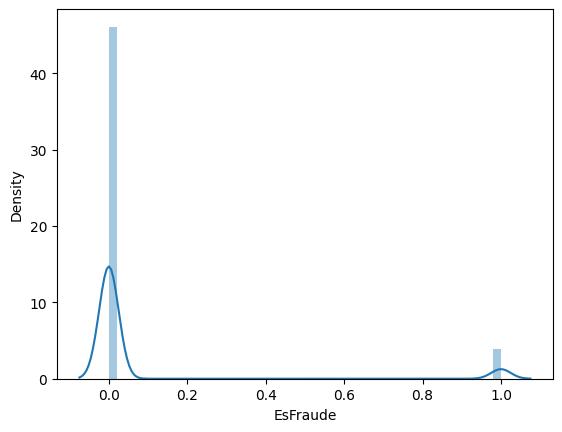

In [26]:
#Distribución de la variable objetivo
sns.distplot(df['EsFraude'])

In [39]:
unique_values = df['EsFraude'].unique()
print(unique_values)

[0 1]


In [40]:
#Ahora mediremos el sesgo de nuestra variable objetivo
print('Skewness de la variable objetivo {:.1f}%'.format(round((df['EsFraude'].skew()),1)))

Skewness de la variable objetivo 3.1%


Observación:
La variable objetivo presenta una asimetria muy pronunciada hacia la izquierda.
Se puede arreglar esta asimetria aplicando una transformación logaritmica.

In [59]:
df.head()

,IdTransaccion,Proxy,SistemaOperativo,Navegador,Resolucion,TipoDispositivo,InfoDispositivo,EsFraude,LineaDeTiempo,MontoTransaccion,Franquicia,TipoTarjeta,DominioCompra
0,2987004,NaN,android 7.0,samsung browser 6.2,2220x1080,mobile,SAMSUNG SM-G892A Build/NRD90M,0,86506,50.000,mastercard,credit,gmail.com
1,2987008,NaN,ios 11.1.2,mobile safari 11.0,1334x750,mobile,iOS Device,0,86535,15.000,visa,debit,anonymous.com
2,2987010,NaN,NaN,chrome 62.0,NaN,desktop,Windows,0,86549,75.887,mastercard,credit,gmail.com
3,2987011,NaN,NaN,chrome 62.0,NaN,desktop,NaN,0,86555,16.495,mastercard,debit,hotmail.com
4,2987016,NaN,mac os x 10.11.6,chrome 62.0,1280x800,desktop,MacOS,0,86620,30.000,visa,debit,aol.com


In [60]:
unique_values = df['EsFraude'].unique()
print(unique_values)

[0 1]


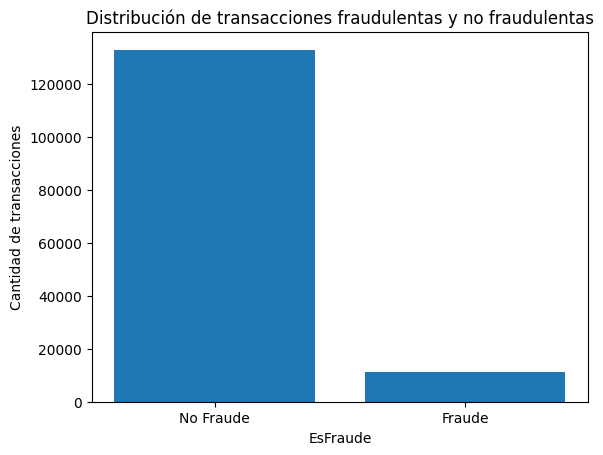

Porcentaje de transacciones fraudulentas: 7.85%
Porcentaje de transacciones no fraudulentas: 92.15%


In [61]:
import matplotlib.pyplot as plt

fraud_count = df['EsFraude'].value_counts()
fraud_percentage = fraud_count / len(df) * 100
plt.bar(fraud_count.index, fraud_count.values)
plt.xlabel('EsFraude')
plt.ylabel('Cantidad de transacciones')
plt.xticks(fraud_count.index, ['No Fraude', 'Fraude'])
plt.title('Distribución de transacciones fraudulentas y no fraudulentas')
plt.show()
print("Porcentaje de transacciones fraudulentas: {:.2f}%".format(fraud_percentage[1]))
print("Porcentaje de transacciones no fraudulentas: {:.2f}%".format(fraud_percentage[0]))


## 3. Exploración de variables

In [108]:
df.describe()


,IdTransaccion,EsFraude,LineaDeTiempo,MontoTransaccion
count,1.442330e+05,144233.000000,1.442330e+05,144233.000000
mean,3.236329e+06,0.078470,6.166958e+06,83.554533
std,1.788496e+05,0.268911,4.807714e+06,99.850258
min,2.987004e+06,0.000000,8.650600e+04,0.251000
25%,3.077142e+06,0.000000,1.885289e+06,25.453000
50%,3.198818e+06,0.000000,4.913738e+06,50.000000
75%,3.392923e+06,0.000000,1.025794e+07,100.000000
max,3.577534e+06,1.000000,1.581103e+07,1800.000000


Tenemos 144.233 datos en Fraude

La media de las transacciones es de 83 dolares, con un minimo de 0.25 centavos de dolar y un máximo de 1.800 dolares.

Podriamos decir que los montos para hacer fraudes son inferiores a 1.800 dólares

#### 3.1. Franquicias

In [87]:
transacciones.columns

Index(['IdTransaccion', 'EsFraude', 'LineaDeTiempo', 'MontoTransaccion',
       'Franquicia', 'TipoTarjeta', 'DominioCompra'],
      dtype='object')

In [62]:
import plotly.graph_objects as go

count_franquicias = df['Franquicia'].value_counts()
fig = go.Figure(data=[go.Pie(labels=count_franquicias.index, values=count_franquicias)])
fig.update_layout(
    title='Distribución de Transacciones por Franquicia',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)
fig.show()


Aquí podemos notar lo siguiente:

La franquicia más usada es Visa con un 61.9%
Luego mastercard con un 30.6%

Con esta dos ya tenemos más de un 90% de las transacciones totales del dataset.

#### 3.2. Tipo de dispositivo

In [63]:
import plotly.graph_objects as go

conteo_dispositivo = df['TipoDispositivo'].value_counts()
fig = go.Figure(data=[go.Pie(
    labels=conteo_dispositivo.index,
    values=conteo_dispositivo.values,
    hole=0.4
)])
fig.update_layout(
    title='Distribución de Transacciones por Tipo de Dispositivo',
    showlegend=True
)

fig.show()


Podemos observar que se hacen más transacciones desde los equipos de escritorio que desde los celulares.

#### 3.3. Sistema Operativo

In [64]:
import plotly.graph_objects as go
valores = df['SistemaOperativo'].value_counts().values
etiquetas = df['SistemaOperativo'].value_counts().index
fig = go.Figure(data=[go.Bar(
    y=etiquetas,
    x=valores,
    orientation='h'
)])

fig.update_layout(
    title='Distribución de Transacciones por Sistema Operativo',
    xaxis_title='Cantidad de Transacciones',
    yaxis_title='Sistema Operativo',
    showlegend=False
)

fig.show()


El sistema operativo más usado es Windows 10 con más de 20.000 datos
y de segundo es android 7.0

Cabe anotar que esta base de datos es anterior a la aparición de Windows 11

#### 3.4. Tipo de dispositivo vs Monto de la transacción

In [65]:
import plotly.graph_objects as go

monto_total = df.groupby('TipoDispositivo')['MontoTransaccion'].sum()
fig = go.Figure(data=[go.Bar(
    x=monto_total.index,
    y=monto_total.values
)])

fig.update_layout(
    title='Monto Total de Transacciones por Tipo de Dispositivo',
    xaxis_title='Tipo de Dispositivo',
    yaxis_title='Monto Total',
    showlegend=False
)

fig.show()


Podemos ver que desde los dispositivos tipo desktop o laptop se hacen muchisimas más transacaciones en monto de dinero que desde el teléfono celular-.

In [73]:
import plotly.express as px

fraud_by_tipo_dispositivo = df[df['EsFraude'] == True]['TipoDispositivo'].value_counts()

fig = px.bar(fraud_by_tipo_dispositivo, x=fraud_by_tipo_dispositivo.index, y=fraud_by_tipo_dispositivo.values)
fig.update_layout(title='Cantidad de fraudes por tipo de dispositivo',
                  xaxis_title='Tipo de Dispositivo',
                  yaxis_title='Cantidad de fraudes')

fig.show()


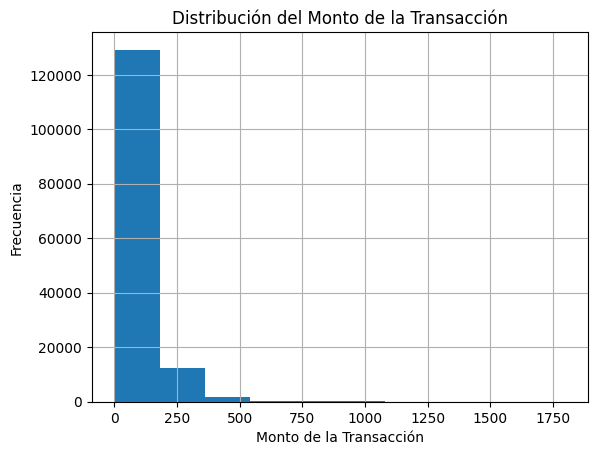

In [66]:
df['MontoTransaccion'].hist()
plt.xlabel('Monto de la Transacción')
plt.ylabel('Frecuencia')
plt.title('Distribución del Monto de la Transacción')
plt.show()


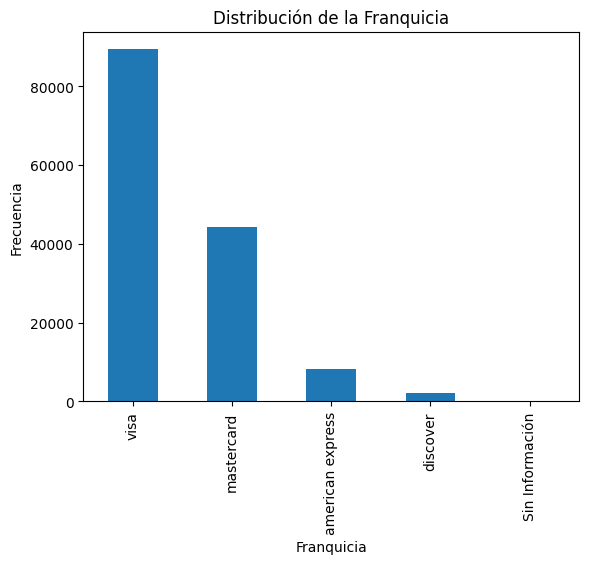

In [67]:
#Distribución de las variables categóricas
df['Franquicia'].value_counts().plot(kind='bar')
plt.xlabel('Franquicia')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Franquicia')
plt.show()


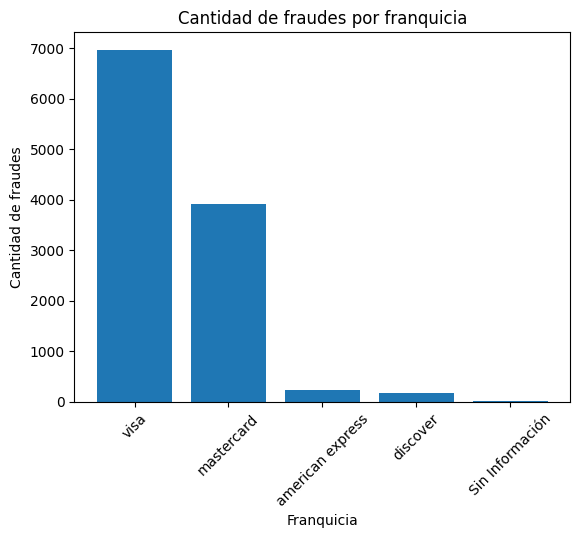

In [69]:
fraudes_por_franquicia = df[df['EsFraude'] == True]['Franquicia'].value_counts()

plt.bar(fraudes_por_franquicia.index, fraudes_por_franquicia.values)
plt.xlabel('Franquicia')
plt.ylabel('Cantidad de fraudes')
plt.title('Cantidad de fraudes por franquicia')
plt.xticks(rotation=45)
plt.show()


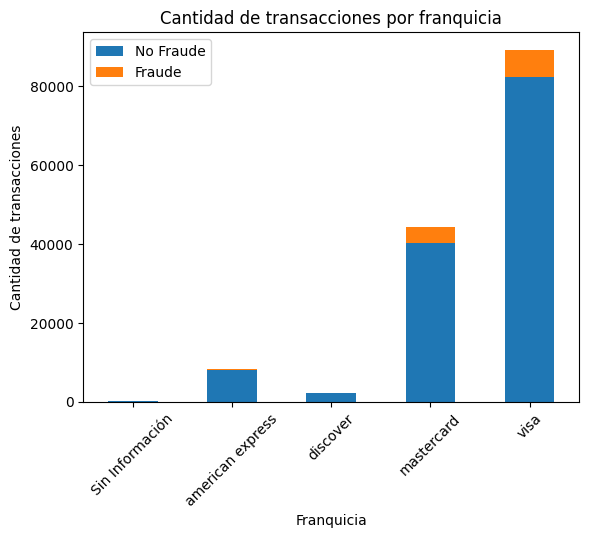

In [70]:
fraude_por_franquicia = df.groupby('Franquicia')['EsFraude'].value_counts().unstack().fillna(0)

fraude_por_franquicia.plot(kind='bar', stacked=True)
plt.xlabel('Franquicia')
plt.ylabel('Cantidad de transacciones')
plt.title('Cantidad de transacciones por franquicia')
plt.legend(['No Fraude', 'Fraude'])
plt.xticks(rotation=45)
plt.show()


#### 3.4. Correlación entre las diferentes variables

In [41]:
#Matriz de correlaciones
corr_matrix = df.corr()

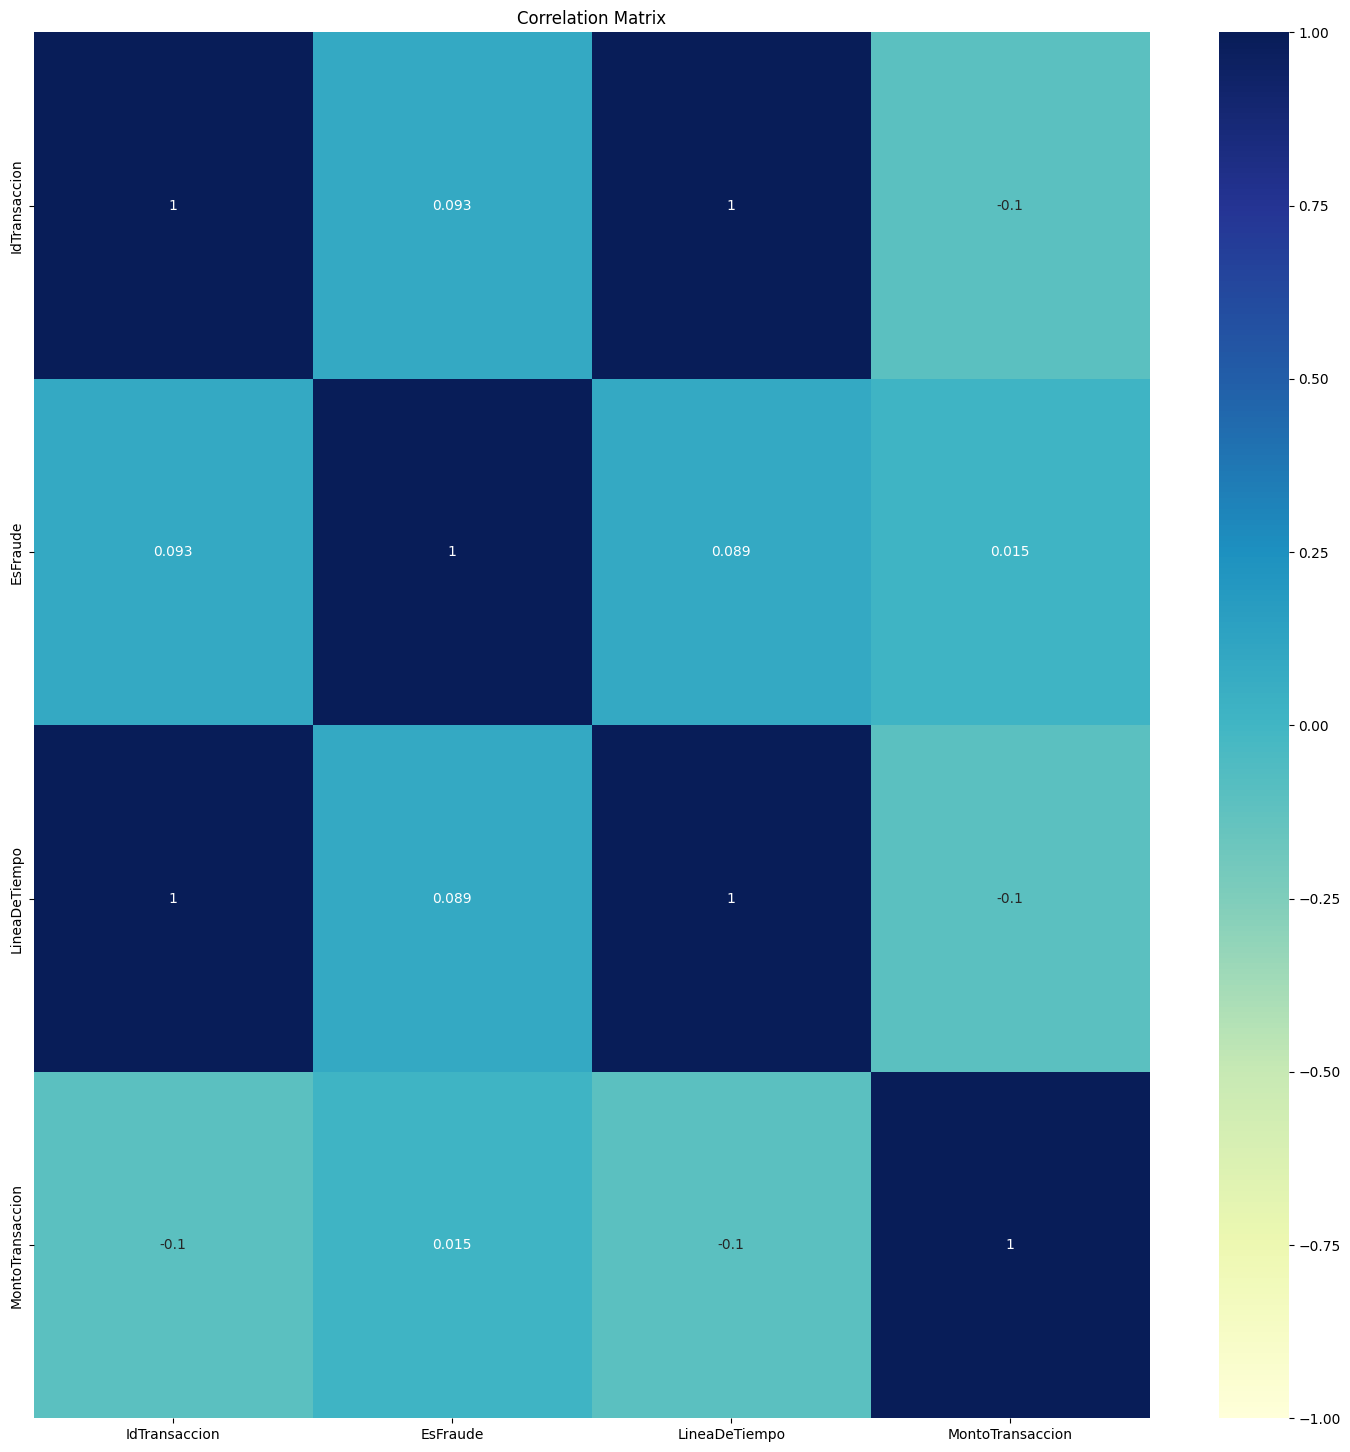

In [42]:
#Gráfico de la matriz de correlaciones
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [53]:
#Correlaciones de las variables con la variable objetivo
target_corr_df = pd.DataFrame(corr_matrix["EsFraude"].sort_values(ascending=False))
target_corr_df 

,EsFraude
EsFraude,1.000000
IdTransaccion,0.092935
LineaDeTiempo,0.089427
MontoTransaccion,0.015360


#### 3.5 Distribución de las variables numéricas

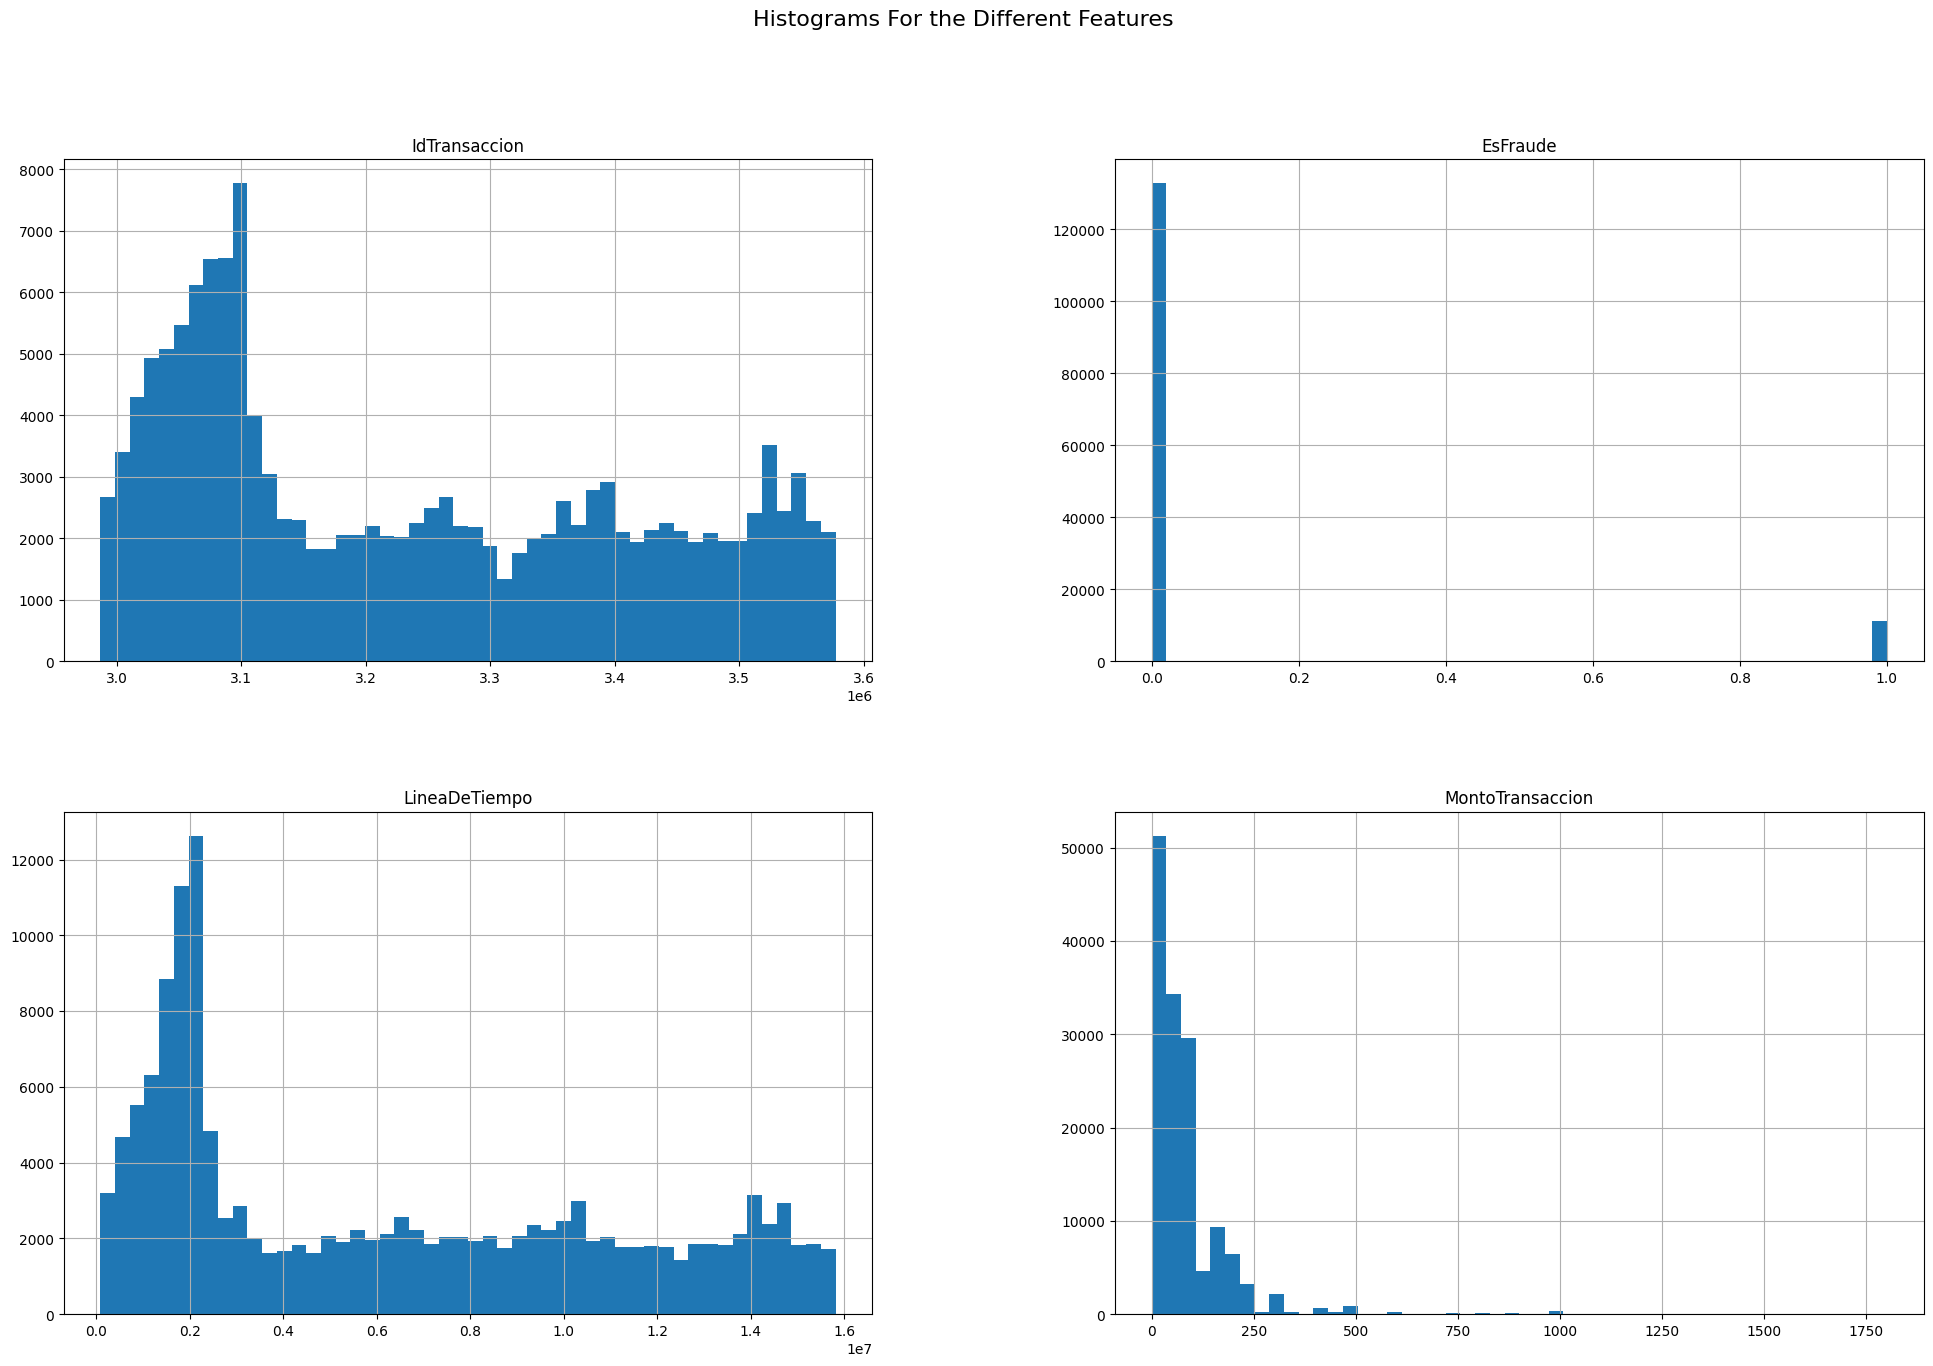

In [54]:
#Gráficos de los histogramas de las distribuciones de las variables
df.hist(bins=50, figsize=(24,15))
plt.suptitle('Histograms For the Different Features', fontsize=16)
plt.show()

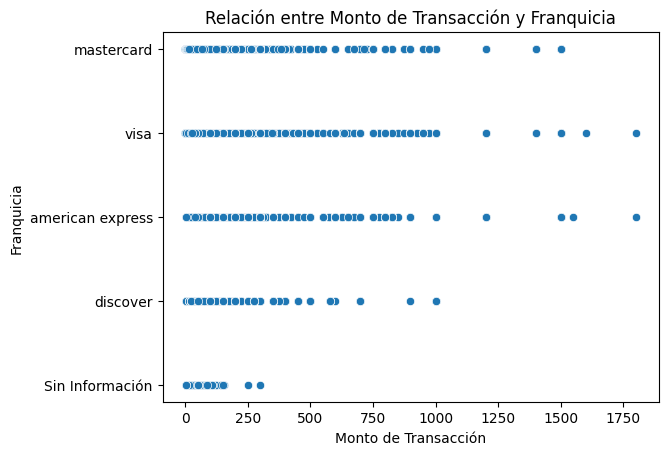

In [113]:
sns.scatterplot(x='MontoTransaccion', y='Franquicia', data=df)
plt.xlabel('Monto de Transacción')
plt.ylabel('Franquicia')
plt.title('Relación entre Monto de Transacción y Franquicia')
plt.show()


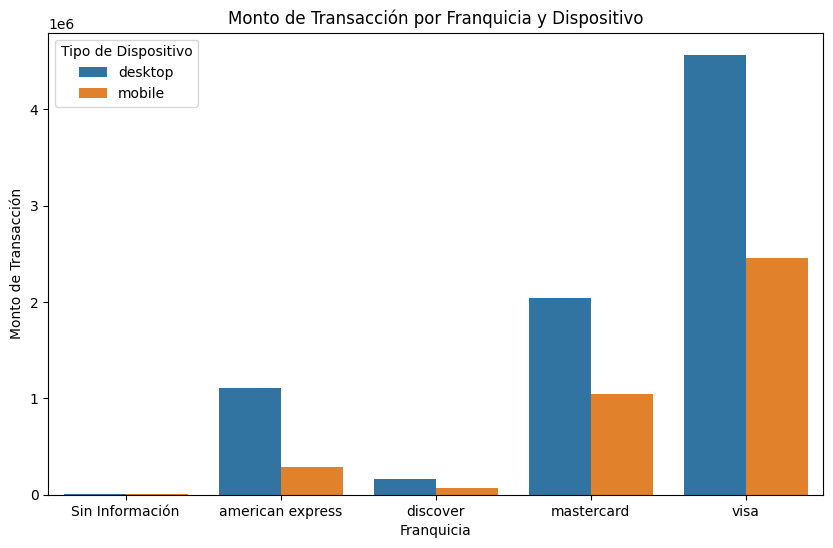

In [74]:
import matplotlib.pyplot as plt

grouped_df = df.groupby(['Franquicia', 'TipoDispositivo'])['MontoTransaccion'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Franquicia', y='MontoTransaccion', hue='TipoDispositivo', data=grouped_df)
plt.xlabel('Franquicia')
plt.ylabel('Monto de Transacción')
plt.title('Monto de Transacción por Franquicia y Dispositivo')
plt.legend(title='Tipo de Dispositivo')
plt.show()


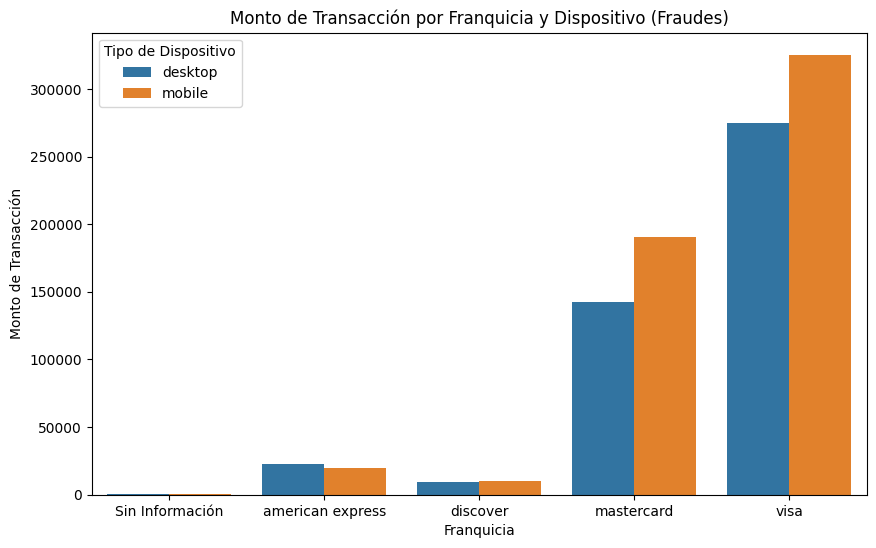

In [75]:
#Ahora solo cuando es sospechoso de fraude
fraud_df = df[df['EsFraude'] == 1]

grouped_df = fraud_df.groupby(['Franquicia', 'TipoDispositivo'])['MontoTransaccion'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Franquicia', y='MontoTransaccion', hue='TipoDispositivo', data=grouped_df)
plt.xlabel('Franquicia')
plt.ylabel('Monto de Transacción')
plt.title('Monto de Transacción por Franquicia y Dispositivo (Fraudes)')
plt.legend(title='Tipo de Dispositivo')
plt.show()


In [79]:
sub = pd.read_csv('sample_submission.csv')
sub

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


In [80]:
unique_values = sub['isFraud'].unique()
print(unique_values)

[0.5]


In [76]:
df.columns

Index(['IdTransaccion', 'Proxy', 'SistemaOperativo', 'Navegador', 'Resolucion',
       'TipoDispositivo', 'InfoDispositivo', 'EsFraude', 'LineaDeTiempo',
       'MontoTransaccion', 'Franquicia', 'TipoTarjeta', 'DominioCompra'],
      dtype='object')

In [82]:
transacciones.columns

Index(['IdTransaccion', 'EsFraude', 'LineaDeTiempo', 'MontoTransaccion',
       'Franquicia', 'TipoTarjeta', 'DominioCompra'],
      dtype='object')

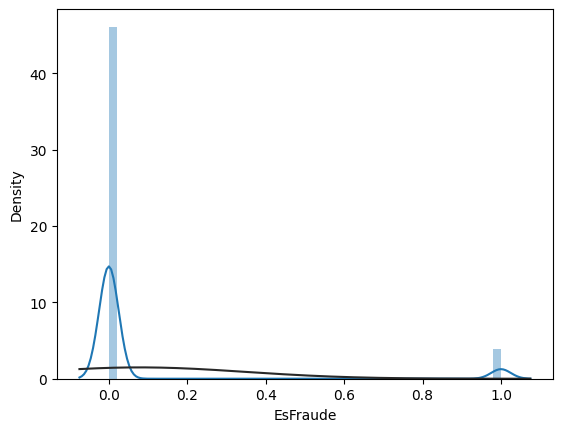

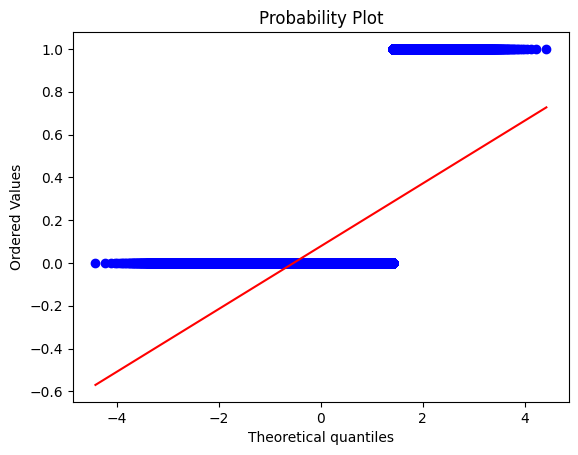

In [92]:
sns.distplot(df['EsFraude'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['EsFraude'], plot=plt)

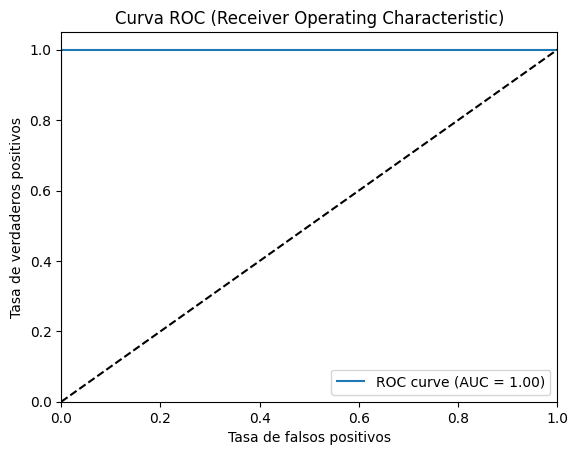

Área bajo la curva ROC (AUC-ROC): 1.0000


In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades de la clase positiva del modelo
probabilities = df['EsFraude']

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(df['EsFraude'], probabilities)

# Calcular el área bajo la curva ROC
auc_roc = roc_auc_score(df['EsFraude'], probabilities)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

# Imprimir el valor del área bajo la curva ROC
print("Área bajo la curva ROC (AUC-ROC): {:.4f}".format(auc_roc))


In [14]:
# Reemplazar "Sin Información" con NaN
df.replace('Sin Información', np.nan, inplace=True)

NameError: ignored

In [57]:
df.dtypes

IdTransaccion         int64
Proxy                object
SistemaOperativo     object
Navegador            object
Resolucion           object
TipoDispositivo      object
InfoDispositivo      object
EsFraude              int64
LineaDeTiempo         int64
MontoTransaccion    float64
Franquicia           object
TipoTarjeta          object
DominioCompra        object
dtype: object

In [58]:
X = df[['Proxy', 'SistemaOperativo', 'Navegador', 'Resolucion',
       'TipoDispositivo', 'InfoDispositivo', 'LineaDeTiempo',
       'MontoTransaccion', 'Franquicia', 'TipoTarjeta', 'DominioCompra']]
y = df['EsFraude']


In [59]:
X_encoded = pd.get_dummies(X)


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [61]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [62]:
y_pred = model.predict(X_test)


In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     26587
           1       0.00      0.00      0.00      2260

    accuracy                           0.92     28847
   macro avg       0.46      0.50      0.48     28847
weighted avg       0.85      0.92      0.88     28847



Con esto tenemos que los resultados obtenidos son muy bajos para lo que necesitamos. 

o la técnica de balanceo de datos mediante el sobremuestreo de la clase minoritaria (fraude) con la biblioteca imbalanced-learn. Además, se utiliza la validación cruzada estratificada para evaluar el rendimiento del modelo de regresión logística:

In [21]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# Dividir los datos en características (variables independientes) y la variable objetivo (variable dependiente)
X = df.drop('EsFraude', axis=1)
y = df['EsFraude']

# Identificar las columnas categóricas y numéricas
categorical_cols = [col for col, dtype in zip(X.columns, X.dtypes) if dtype == 'object']
numeric_cols = [col for col, dtype in zip(X.columns, X.dtypes) if dtype != 'object']

# Aplicar la codificación one-hot a las variables categóricas
ct = ColumnTransformer([('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Realizar sobremuestreo de la clase minoritaria utilizando SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Realizar validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar una lista para almacenar los resultados de evaluación en cada iteración de validación cruzada
results = []

# Iterar sobre cada fold de la validación cruzada
for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
    # Crear y entrenar el modelo de regresión logística
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Evaluar el rendimiento del modelo
    report = classification_report(y_test, y_pred)
    results.append(report)

# Imprimir los resultados de evaluación promediados en cada iteración de validación cruzada
print("Resultados de evaluación promediados en validación cruzada:")
print("--------------------------------------------------------")
print(pd.DataFrame(results).mean())


Resultados de evaluación promediados en validación cruzada:
--------------------------------------------------------
Series([], dtype: float64)


Este código utiliza la biblioteca imbalanced-learn para aplicar la técnica de sobremuestreo SMOTE, que genera nuevas instancias sintéticas de la clase minoritaria para equilibrar la distribución de las clases. Luego, se realiza la validación cruzada estratificada utilizando StratifiedKFold para dividir los datos en conjuntos de entrenamiento y prueba en cada iteración.

Dentro del bucle de validación cruzada, se crea y entrena un modelo de regresión logística en el conjunto de entrenamiento y se evalúa su rendimiento en el conjunto de prueba utilizando classification_report. Finalmente, los resultados se promedian en todas las iteraciones de validación cruzada para obtener una medida general del rendimiento del modelo.